In [4]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('~/mycode/python/data_analyze/data/HR.csv')

### 独立T分布检验

In [2]:
dp_indices = df.groupby('department').indices
sales_values = df["left"].iloc[dp_indices['sales']].values
technical_values = df["left"].iloc[dp_indices["technical"]].values
ss.ttest_ind(sales_values, technical_values)


Ttest_indResult(statistic=-1.0601649378624074, pvalue=0.28910690461744781)

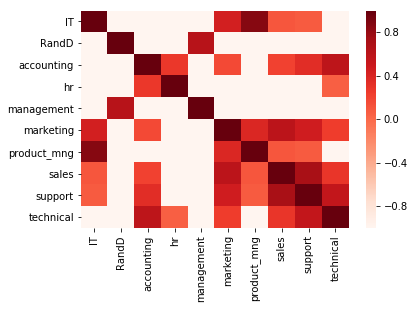

In [3]:
dp_keys = list(dp_indices.keys())
dp_t_mat = np.zeros([len(dp_keys),len(dp_keys)])
for i in range(len(dp_keys)):
    for j in range(len(dp_keys)):
        p_value = ss.ttest_ind(df["left"].iloc[dp_indices[dp_keys[i]]].values,
                              df['left'].iloc[dp_indices[dp_keys[j]]].values)[1]
        if p_value < 0.05:
            dp_t_mat[i][j] = -1
        else:
            dp_t_mat[i][j] = p_value
sns.heatmap(dp_t_mat,xticklabels = dp_keys, yticklabels = dp_keys,cmap=sns.color_palette("Reds",n_colors=256))
plt.show()

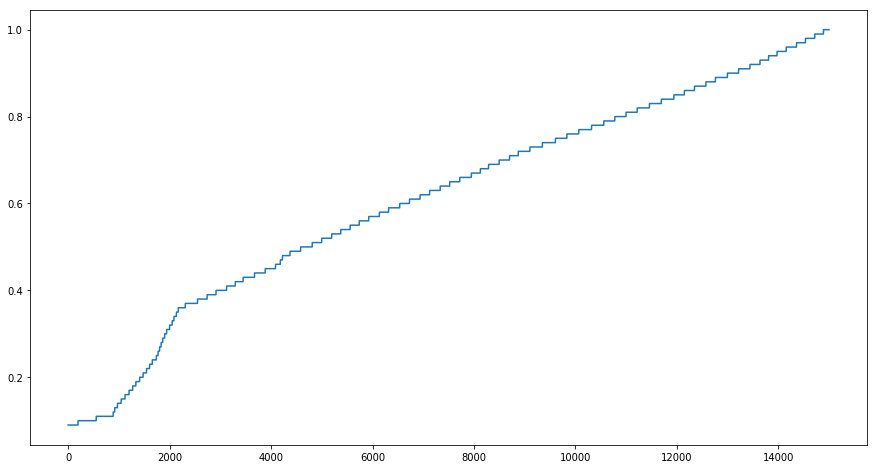

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(df.index.values, df['satisfaction_level'].sort_values().values)
plt.show()

## 交叉分析-透视表

In [4]:
df
piv_tb = pd.pivot_table(df,values="left", index=["promotion_last_5years","salary"],
                       columns=["Work_accident"],
                       aggfunc=np.mean)
print(type(piv_tb))
piv_tb

<class 'pandas.core.frame.DataFrame'>


Work_accident                        0         1
promotion_last_5years salary                    
0                     high    0.082996  0.000000
                      low     0.331728  0.090020
                      medium  0.230683  0.081655
1                     high    0.000000  0.000000
                      low     0.229167  0.166667
                      medium  0.028986  0.023256

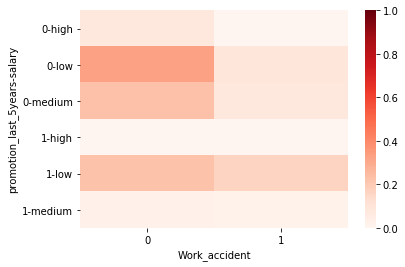

In [5]:
sns.heatmap(piv_tb,vmin=0,vmax=1,cmap=sns.color_palette("Reds",n_colors=256))
plt.show()

## 分组分析
将数据进行分组后进行分析

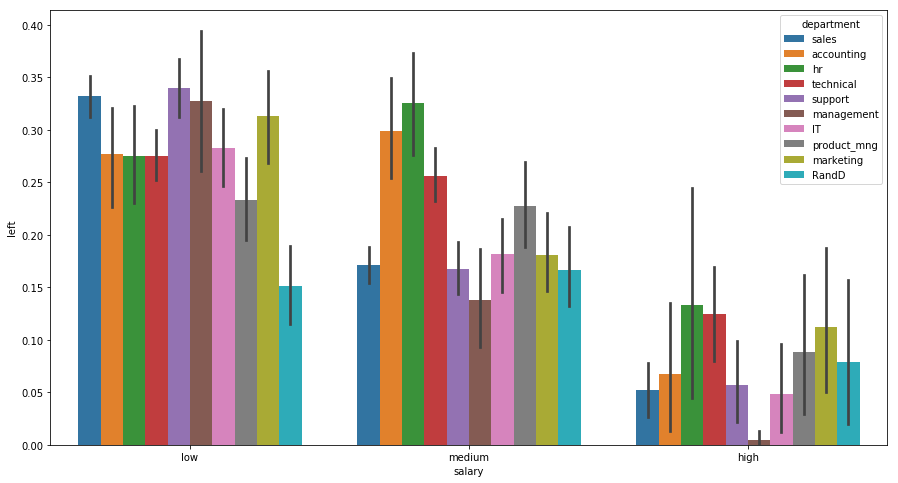

In [6]:
plt.figure(figsize=(15, 8))
sns.barplot(data=df,x="salary",y="left",hue="department")
plt.show()

### 相关分析

In [7]:
#对于离散值属性会在计算中忽略
df.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.104966,-0.143084,-0.020137,-0.100893,0.058672,-0.388309,0.025596
last_evaluation,0.104966,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.143084,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020137,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100893,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058672,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388309,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025596,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


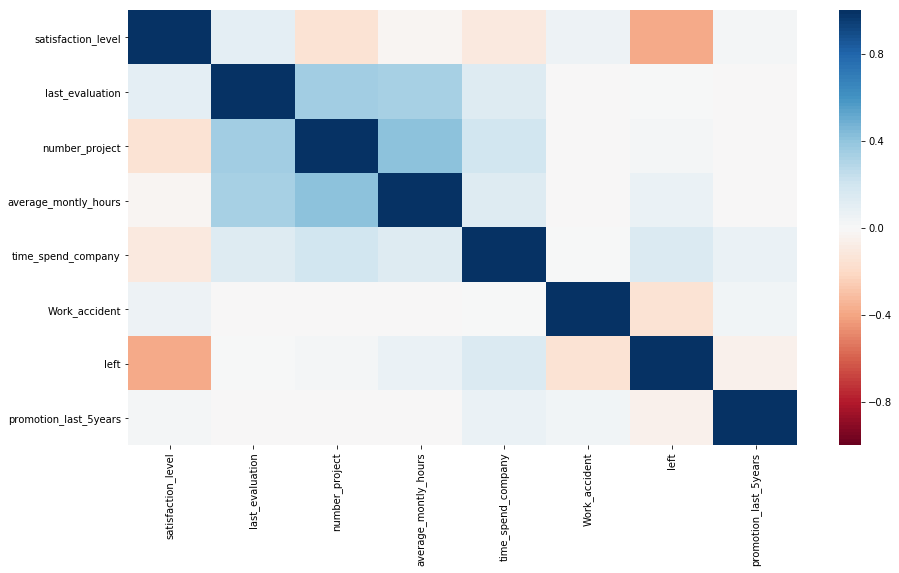

In [8]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap=sns.color_palette("RdBu",n_colors=128))
plt.show()

### 对于分类属性计算相关性
#### 熵：描述属性不确定性的值，越接近于0，其不确定性越小
$$
    H(X) = -\Sigma{p_i}log(p_i)
$$
#### 条件熵：描述在X条件下Y的熵
$$
    H(Y|X) = \Sigma p(x_i)H(Y|X=x_i)
$$
#### 互信息（熵增益）
$$
    I(X,Y) = H(Y) - H(Y|X)
$$
#### 熵增益率
$$
    GainRatio(X -> Y) = \frac{I(X,Y)}{H(Y)}
$$
#### 相关性，离散值的相关性度量
$$
    Corr(X,Y) = \frac{I(X,Y)}{\sqrt{H(X)H(Y)}}
$$

In [42]:
s1 = pd.Series(["中学","中学","大学","大学","大学","研究生","中学","研究生"])
s2 = pd.Series(["中收入","低收入","低收入","中收入","中收入","高收入","低收入","低收入"])


In [58]:
#熵计算
def getEntropy(s):
    if not isinstance(s,pd.core.series.Series):
        s = pd.Series(s)
    pArray = s.groupby(s).count().values/float(len(s))
    return -(np.log2(pArray) * pArray).sum()

def getCondEntropy(s1,s2):
    d = dict()
    for i in list(range(len(s1))):
        d[s1[i]]=d.get(s1[i],[])+[s2[i]]
    return sum([getEntropy(d[k])*len(d[k])/float(len(s1)) for k in d])
def getEntropyGain(s1,s2):
    return getEntropy(s2) - getCondEntropy(s1,s2)
def getEntropyGainRatio(s1,s2):
    return getEntropyGain(s1,s2)/getEntropy(s2)
import math
def getDiscreteCorr(s1,s2):
    return getEntropyGain(s1,s2)/math.sqrt(getEntropy(s1)*getEntropy(s2))

In [61]:
print("熵s1:",getEntropy(s1))
print("熵s2:",getEntropy(s2))
print("条件熵s1,s2:",getCondEntropy(s1,s2))
print("条件熵s2,s1:",getCondEntropy(s2,s1))
print("熵增益:",getEntropyGain(s1,s2))
print("熵增益率s1,s2:",getEntropyGainRatio(s1,s2))
print("熵增益率s2,s1:",getEntropyGainRatio(s1,s2))
print("相关性:", getDiscreteCorr(s1,s2))

熵s1: 1.56127812446
熵s2: 1.40563906223
条件熵s1,s2: 0.938721875541
条件熵s2,s1: 1.09436093777
熵增益: 0.466917186689
熵增益率s1,s2: 0.332174310771
熵增益率s2,s1: 0.332174310771
相关性: 0.315183021069


### 基尼系数

In [67]:
def getProbSS(s):
    if not isinstance(s,pd.core.series.Series):
        s = pd.Series(s)
    pArray = s.groupby(s).count().values/float(len(s))
    return sum(pArray ** pArray)
def getGini(s1,s2):
    d = dict()
    for i in list(range(len(s1))):
        d[s1[i]]=d.get(s1[i],[])+[s2[i]]
    return 1 - sum([getProbSS(d[k]) * len(d[k]) / float(len(s1)) for k in d])

In [68]:
getProbSS(s1)
getGini(s1,s2)

-0.44593146763291558